# **main dataset (PAAD CRA) SVM RF KNN**

In [ ]:
# Imports   
import numpy as np   
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix


In [ ]:
# Mounting GoogleDrive where data is stored
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
#filename = 'svm_linear_model_first_7pt.sav'
directory = '/gdrive/My Drive/BMEN4480_Final_Project/'


# **data import**

In [ ]:
# Import data
# Use the below to import the data in chuncks. This will take about 20-25 minutes
# THIS IS THE BIG FILE
# from pandas import *
tp = pd.read_csv(r'/gdrive/My Drive/BMEN4480_Final_Project/BMEN4480_data_log_prescvi_cell_types.csv', iterator=True, chunksize=10000)
df = pd.concat(tp, ignore_index=True) 


In [ ]:
# save this now for SVM
features_names = df.columns[1:19001].to_numpy() #feature names

In [ ]:
# Check file and counts per class
print(df.shape)
df.cell_type.value_counts()

(57443, 19002)


normal           43849
tumor class 1    11344
tumor class 2     2250
Name: cell_type, dtype: int64

In [ ]:
# 3 CLASSES

# change classes to 0, 1, 2
tumor = {'tumor class 1': 1, 'tumor class 2': 2, 'normal':0}
df.cell_type = [tumor[item] for item in df.cell_type]

In [ ]:
# 2 CLASSES

# change classes to 0, 1
tumor = {'tumor class 1': 1, 'tumor class 2': 1, 'normal':0}
df.cell_type = [tumor[item] for item in df.cell_type]

In [ ]:
# Rename the first column Cell
df = df.rename(columns={"Unnamed: 0": "Cell"})

In [ ]:
# create a new variable to identify patients (from the first two letters of the cell name)
df['Patient'] = df.Cell.str[:3]

In [ ]:
# look at cells per patient to choose a smaller dataset to work with
df.Patient.value_counts()

T11    3141
T2_    3040
T19    2927
T23    2865
N1_    2823
N9_    2468
T9_    2354
T12    2269
T22    2215
T17    2085
T13    2058
T14    1998
N2_    1956
T15    1956
T6_    1871
T24    1811
T16    1634
T18    1562
N10    1522
N11    1365
T3_    1316
N8_    1191
T1_    1171
T5_    1115
N7_    1114
T4_    1027
N4_     974
N5_     885
T10     828
T21     807
T7_     747
N6_     717
T8_     697
T20     482
N3_     452
Name: Patient, dtype: int64

In [ ]:
# extract random sample from the big file to create a work file
# THIS IS THE SMALLER FILE TO BE USED TO TEST THE PROGRAM

# choose by patient, so can stratify by patient and avoid batch effects

small_df = df[df.Patient.isin(['T11','T2_','T19','T23','N1_','N9_','T9_','T12','T22'])] #more cells/patient, less patients. top list
# small_df = df[df.Patient.isin(['N3_','T20','T8_','N6','T7_','T21','T10','N5_','N4_','T4_','N7_','T5_','T1_','N8_','N8_','T3_','N11','N10','T18','T16'])] # bottom list

In [ ]:
del df

In [ ]:
small_df.cell_type.value_counts()

0    19693
1     4409
Name: cell_type, dtype: int64

In [ ]:
# create train and test samples stratified by patient
from sklearn.model_selection import train_test_split
small_df_train, small_df_test = train_test_split(small_df, test_size=0.2, stratify=small_df[["Patient"]])

In [ ]:
del small_df

In [ ]:
# Remove class, cell name, and patient name from X. just genes.
X_Test = small_df_test.drop(columns=['cell_type','Cell','Patient']).to_numpy()

In [ ]:
Y_Test = small_df_test[['cell_type']]
Y_Test = Y_Test.to_numpy().flatten()

In [ ]:
# create np.array for X
X_Train = small_df_train.drop(columns=['cell_type','Patient','Cell']).to_numpy()

In [ ]:
# create np.array for Y
Y_Train = small_df_train[['cell_type']]
Y_Train = Y_Train.to_numpy().flatten()

In [ ]:
del small_df_test, small_df_train

# **meta data-- not used**

In [ ]:
# import meta data file
# data_meta=pd.read_csv('/gdrive/My Drive/BMEN4480_Final_Project/PAAD_CRA001160_CellMetainfo_table.tsv',sep='\t')
# data_meta.head(10)

,Cell,UMAP_1,UMAP_2,Celltype (malignancy),Celltype (major-lineage),Celltype (minor-lineage),Celltype (original),Cluster,Celltype,Patient,Source,Age,Gender,Stage,TNMstage
0,T2_AAAGATGAGCTTCGCG,-1.155559,-4.607106,Others,Acinar,Acinar,Acinar cell,16,Acinar cell,T2,Tumor,52,Male,Primary,IIB
1,T2_AAATGCCCAAGCCGCT,-1.730514,-5.563408,Others,Acinar,Acinar,Acinar cell,23,Acinar cell,T2,Tumor,52,Male,Primary,IIB
2,T2_AAGGCAGCAGGGAGAG,-1.028118,-5.898004,Others,Acinar,Acinar,Acinar cell,23,Acinar cell,T2,Tumor,52,Male,Primary,IIB
3,T2_ACACTGAAGACCACGA,-1.945103,-5.715586,Others,Acinar,Acinar,Acinar cell,23,Acinar cell,T2,Tumor,52,Male,Primary,IIB
4,T2_ACACTGATCCTTTCTC,-1.490242,-5.239794,Others,Acinar,Acinar,Acinar cell,23,Acinar cell,T2,Tumor,52,Male,Primary,IIB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,T6_ATCGAGTGTAAAGTCA,-0.348774,-3.814863,Others,Acinar,Acinar,Acinar cell,16,Acinar cell,T6,Tumor,64,Male,Primary,IIA
96,T6_ATCTGCCTCTGTCCGT,-0.638638,-4.775455,Others,Acinar,Acinar,Acinar cell,23,Acinar cell,T6,Tumor,64,Male,Primary,IIA
97,T6_CACAAACAGGGCACTA,-1.002702,-4.521181,Others,Acinar,Acinar,Acinar cell,16,Acinar cell,T6,Tumor,64,Male,Primary,IIA
98,T6_CACATTTGTGCACGAA,-0.896367,-5.315763,Others,Acinar,Acinar,Acinar cell,23,Acinar cell,T6,Tumor,64,Male,Primary,IIA


In [ ]:
# see cell types. (not used in final analysis)
# data_meta['Celltype (original)'].value_counts()

Ductal cell type 2    11314
Ductal cell type 1    10317
Endothelial cell       9117
Fibroblast cell        6741
Stellate cell          5907
Macrophage cell        5361
T cell                 3659
B cell                 2447
Acinar cell            1854
Endocrine cell          726
Name: Celltype (original), dtype: int64

In [ ]:
# data_meta.shape

(57443, 15)

# **Logistic Regression-- not used**

Can only do for binary classes. Not for multiclass.

In [ ]:
# # logistic regression (not used in final analysis because we switched from binary to multiclass)
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix

In [ ]:
# Informative filtering-- pass each feature and all cells through logistic regression. 
# Look at score after each. See which features are most important (highest statistic)
# Drop genes with low predictive value. 
list_X = []
for i in range(X.shape[1]):
  X_i = X[:,:]
  X_i = X_i.reshape(-1,1)
  list_X.append(X_i)

print(list_X[0])

TypeError: '(slice(None, None, None), slice(None, None, None))' is an invalid key

In [ ]:
list_scores = []

for i in range(len(list_X)):
  clf = LogisticRegression(random_state=0).fit(list_X[i],y_binary)
  score = clf.score(list_X[i],y_binary)
  list_scores.append(score)

In [ ]:
X1 = X[:,4].reshape(-1,1)
clf = LogisticRegression(random_state=0).fit(X1,y_binary)
score = clf.score(X1,y_binary)
print(score)

0.7082151001862717


In [ ]:
list_scores

[0.7307417788068172,
 0.7307417788068172,
 0.7307417788068172,
 0.73082882161447,
 0.7082151001862717,
 0.73269153769824,
 0.7306025103145727,
 0.7307417788068172,
 0.7227686576258204,
 0.7385059972494473]

In [ ]:
Crosstab between healthy cells, tumor cells, healthy patient, tumor patient
(avals, xvals), count = crosstab(data['cell_type'], data['Source'])

In [ ]:
avals

array([0, 1])

In [ ]:
xvals

array([0, 1])

In [ ]:
count

array([[15454, 30645],
       [   13, 11331]])

# **Random Forrest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Run model
#clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
clf_rf.fit(X_Train, Y_Train)
predicted_rf = clf_rf.predict(X_Test)
print(clf_rf.predict(X_Test))

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.metrics import accuracy_score
print("Train set Accuracy: ", accuracy_score(Y_Train, clf_rf.predict(X_Train)))
print("Test set Accuracy: ", accuracy_score(Y_Test, predicted_rf))

Train set Accuracy:  0.9990145739328873
Test set Accuracy:  0.9722049367351172


In [ ]:
print(classification_report(Y_Test,predicted_rf))
print(confusion_matrix(Y_Test,predicted_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3966
           1       0.97      0.92      0.95       696
           2       0.91      0.69      0.78       159

    accuracy                           0.97      4821
   macro avg       0.95      0.87      0.90      4821
weighted avg       0.97      0.97      0.97      4821

[[3936   19   11]
 [  54  642    0]
 [  50    0  109]]


Text(0.5, 15.0, 'Prediction')

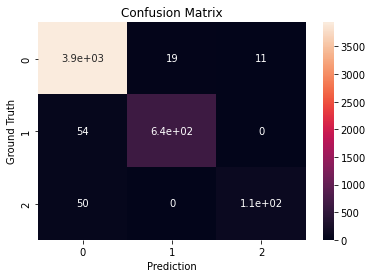

In [ ]:
cm = confusion_matrix(Y_Test, predicted_rf)
sns.heatmap(cm, annot=True)
plt.title(('Confusion Matrix'))
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')

In [ ]:
# save model
import pickle
pickle.dump(clf_rf, open(directory+'rf_model_first_9pt.sav', 'wb'))

# **SVM**

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
clf_svm = svm.SVC(kernel= 'linear')
clf_svm.fit(X_Train,Y_Train)

SVC(kernel='linear')

In [ ]:
#features_names = df.columns[1:19001].to_numpy() #feature names

In [ ]:
# show top #(num_features) important features for coef. set coef[0], coef[1], or coef[2] to see each class.
def f_importances(coef,names,num_features):
    sorted_idx = coef.argsort()
    names = features_names[sorted_idx]
    coef_s = coef[sorted_idx]
    np.save(directory+'SVM_features_2_class', names[-num_features:])
    plt.barh(names[-100:], coef_s[-100:])
    plt.xlabel("Feature Importance")
    plt.rcParams['figure.figsize'] = [26, 23]
    plt.savefig(directory+'SVM_coef_2_class.png', dpi= 100)
    plt.show()

    # uncomment for barplot

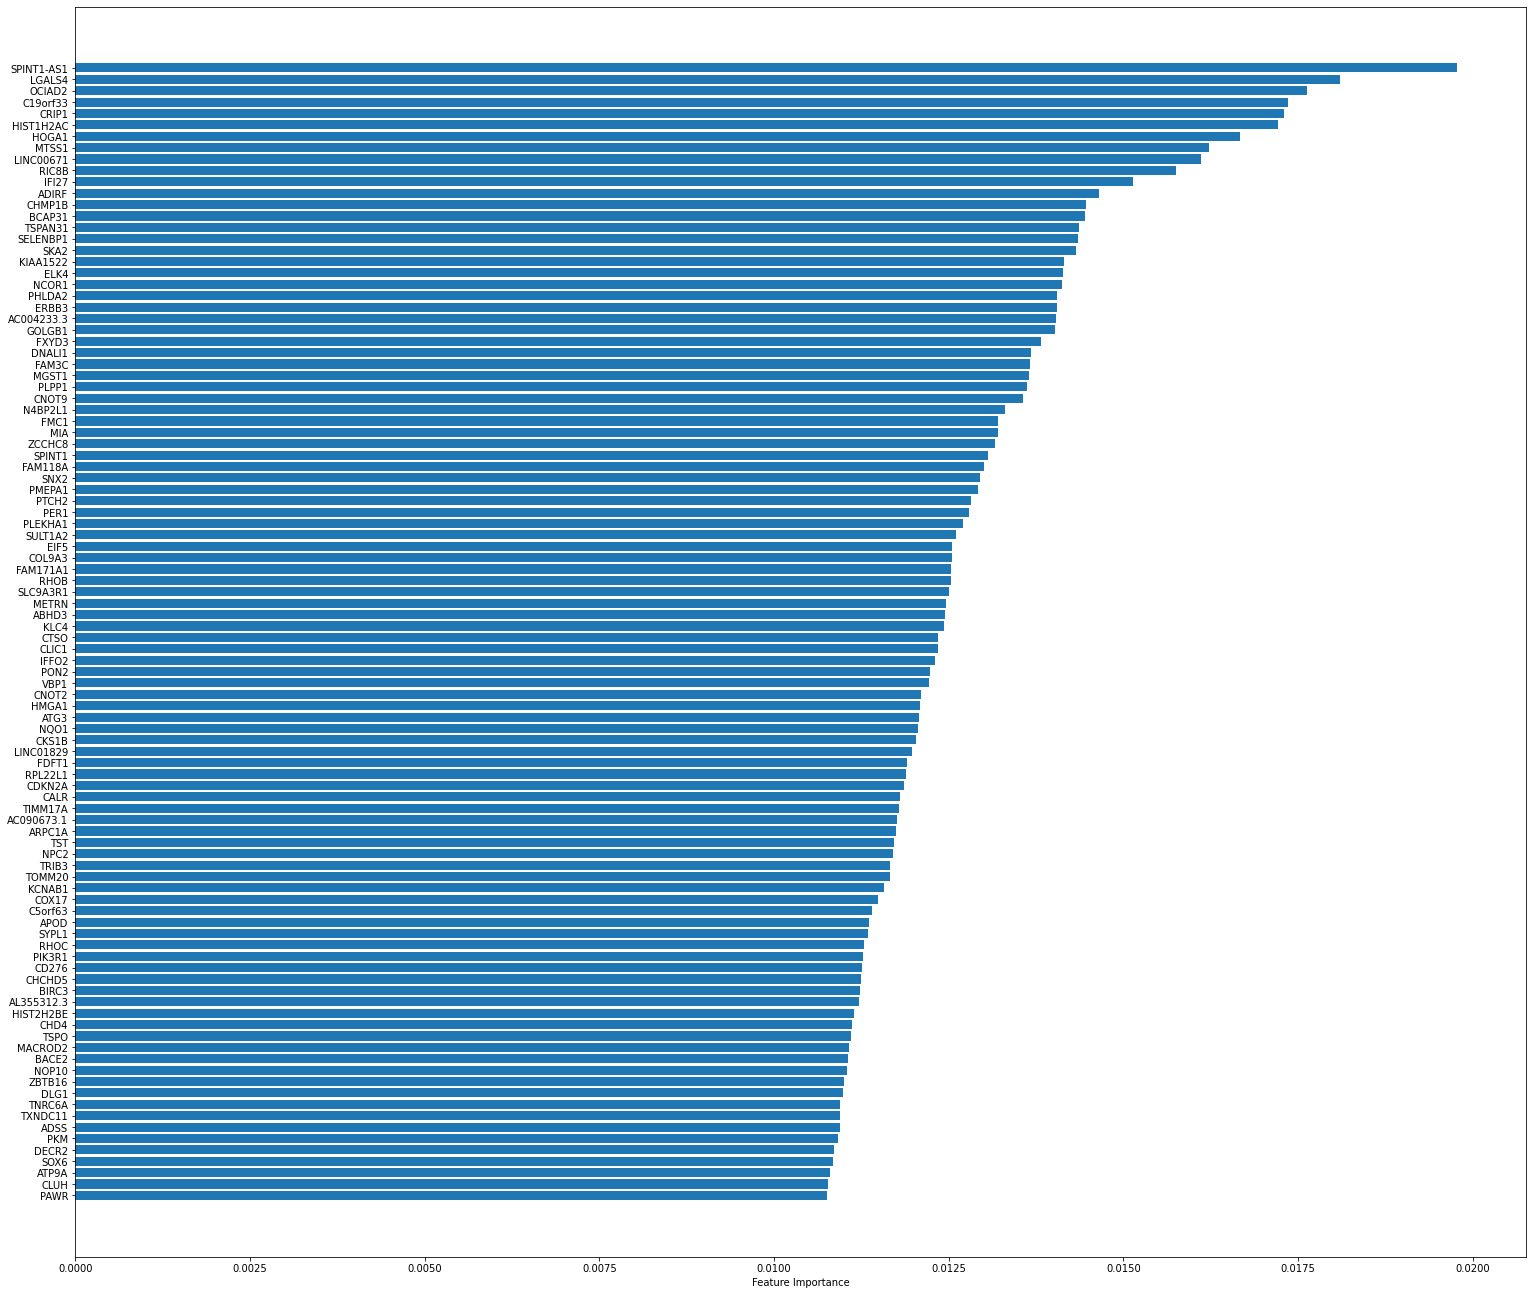

In [ ]:
# get 4,700 for 3 class new dataset
# get 14,100 for 2 class
f_importances(clf_svm.coef_[0], features_names, 14100)

In [ ]:
f_importances(clf_svm.coef_[1], features_names, 4700)

IndexError: ignored

In [ ]:
f_importances(clf_svm.coef_[2], features_names, 4700)

save most important features w/ cells as separate file

In [ ]:
features = np.load(directory+'SVM_features_2_class.npy', allow_pickle=True)

In [ ]:
df_features = df[features]

In [ ]:
df_features.to_pickle(directory+'df_features_2_class_ALL.pkl')

back to model

In [ ]:
# train SVm model
predicted=clf_svm.predict(X_Test)

In [ ]:
from sklearn import metrics
#print("Train set Accuracy: ", metrics.accuracy_score(Y_Train, clf_svm.predict(X_Train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_Test, predicted))

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
print(classification_report(Y_Test,predicted))
print(confusion_matrix(Y_Test,predicted))

NameError: ignored

Text(0.5, 6.0, 'Prediction')

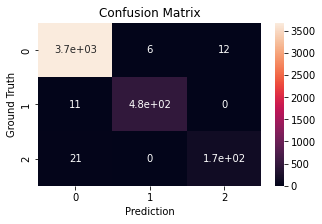

In [ ]:
cm = confusion_matrix(Y_Test, predicted)
sns.heatmap(cm, annot=True)
plt.rcParams['figure.figsize'] = [3, 2]
plt.title(('Confusion Matrix'))
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')

In [ ]:
# save model
import pickle
pickle.dump(clf_svm, open(directory+'svm_linear_model_first_9pt.sav', 'wb'))

In [ ]:
# load model
clf_svm = pickle.load(open(filename, 'rb'))

Retrain model with just most informative genes

## **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k = 4
#Train Model and Predict 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_Train,Y_Train)
neigh

KNeighborsClassifier(n_neighbors=4)

In [ ]:
# yhat = knn_model.predict(X_Test)
yhat = knn_model.predict(small_df_test_X)
yhat[0:5]

array([0, 0, 0, 0, 0])

In [ ]:
from sklearn import metrics
#print("Train set Accuracy: ", metrics.accuracy_score(Y_Train, neigh.predict(X_Train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_Test, yhat))

Train set Accuracy:  0.9677921269643691
Test set Accuracy:  0.936320265505082


In [ ]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_Train,Y_Train)
    yhat=neigh.predict(X_Test)
    mean_acc[n-1] = metrics.accuracy_score(Y_Test, yhat)
 
    std_acc[n-1]=np.std(yhat==Y_Test)/np.sqrt(yhat.shape[0])
    
mean_acc

array([0.87222568, 0.9334163 , 0.88861232, 0.93632027, 0.91723709,
       0.92885294, 0.91619996, 0.92594897, 0.91557768])

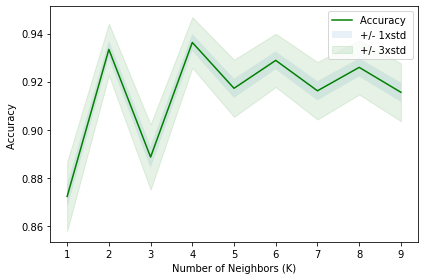

In [ ]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [ ]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.936320265505082 with k= 4


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
print(classification_report(small_df_test_Y,yhat))
print(confusion_matrix(small_df_test_Y,yhat))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     14138
           1       0.94      0.98      0.96      3708
           2       0.44      0.99      0.61      1043

    accuracy                           0.91     18889
   macro avg       0.79      0.96      0.84     18889
weighted avg       0.95      0.91      0.93     18889

[[12593   232  1313]
 [   65  3642     1]
 [    6     0  1037]]


Text(0.5, 15.0, 'Prediction')

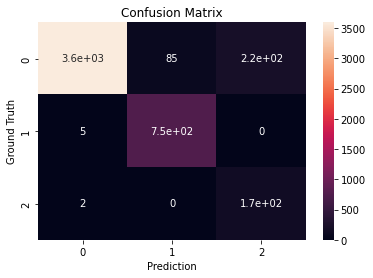

In [ ]:
cm = confusion_matrix(Y_Test, yhat)
sns.heatmap(cm, annot=True)
plt.rcParams['figure.figsize'] = [3, 2]
plt.title(('Confusion Matrix'))
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')

In [ ]:
# save model
import pickle
pickle.dump(neigh, open(directory+'knn_model_first_9pt.sav', 'wb'))

In [ ]:
# load model
# import pickle
# knn_model = pickle.load(open(directory+'knn_model_first_9pt.sav', 'rb'))

## **SVM rbg kernel-- not used**

In [ ]:
rbf_svm = svm.SVC(kernel='rbf')
rbf_svm.fit(X_Train,Y_Train)

SVC()

In [ ]:
predicted = rbf_svm.predict(X_Test)

In [ ]:
accuracy = accuracy_score(Y_Test, predicted)
accuracy

0.206266318537859

In [ ]:
print(accuracy_score(Y_Test,predicted))
print(classification_report(Y_Test,predicted))
print(confusion_matrix(Y_Test,predicted))

0.206266318537859
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       858
           1       0.21      1.00      0.34       237
           2       0.00      0.00      0.00        54

    accuracy                           0.21      1149
   macro avg       0.07      0.33      0.11      1149
weighted avg       0.04      0.21      0.07      1149

[[  0 858   0]
 [  0 237   0]
 [  0  54   0]]


C:\Users\emili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Prediction')

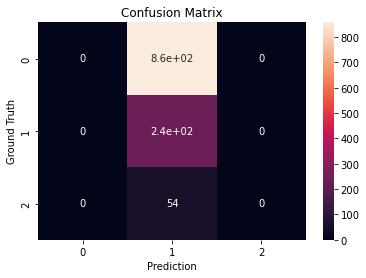

In [ ]:
cm = confusion_matrix(Y_Test, predicted)
sns.heatmap(cm, annot=True)
plt.title(('Confusion Matrix'))
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')

# **svm.NuSVM -- not used**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC
clf_nusvm = make_pipeline(StandardScaler(), NuSVC())
clf_nusvm.fit(X_Train, Y_Train)
Pipeline(steps=[('standardscaler', StandardScaler()), ('nusvc', NuSVC())])

Pipeline(steps=[('standardscaler', StandardScaler()), ('nusvc', NuSVC())])

In [ ]:
predicted = clf_nusvm.predict(X_Test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_Test, predicted)
accuracy

0.206266318537859

In [ ]:
print(accuracy_score(Y_Test,predicted))
print(classification_report(Y_Test,predicted))
print(confusion_matrix(Y_Test,predicted))

0.206266318537859
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       858
           1       0.21      1.00      0.34       237
           2       0.00      0.00      0.00        54

    accuracy                           0.21      1149
   macro avg       0.07      0.33      0.11      1149
weighted avg       0.04      0.21      0.07      1149

[[  0 858   0]
 [  0 237   0]
 [  0  54   0]]


C:\Users\emili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\emili\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Prediction')

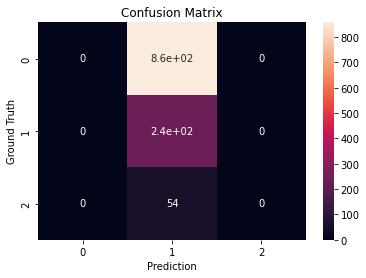

In [ ]:
cm = confusion_matrix(Y_Test, predicted)
sns.heatmap(cm, annot=True)
plt.title(('Confusion Matrix'))
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')

# **Test on other half of dataset**

In [ ]:
del clf_rf
del cm
del predicted

In [ ]:
# load model
import pickle
clf_svm = pickle.load(open(directory+'svm_linear_model_first_9pt.sav', 'rb'))

In [ ]:
predicted=clf_knn.predict(small_df_test_X)

In [ ]:
# make small_df dataset to test on using code above
from sklearn import metrics
print("Test set Accuracy: ", metrics.accuracy_score(small_df_test_Y, predicted))

Test set Accuracy:  0.9143946212081105


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(small_df_test_Y,predicted))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     14138
           1       0.94      0.98      0.96      3708
           2       0.44      0.99      0.61      1043

    accuracy                           0.91     18889
   macro avg       0.79      0.96      0.84     18889
weighted avg       0.95      0.91      0.93     18889



Text(0.5, -3.0, 'Prediction')

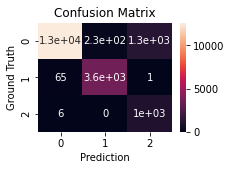

In [ ]:
cm = confusion_matrix(small_df_test_Y, predicted)
sns.heatmap(cm, annot=True)
plt.rcParams['figure.figsize'] = [3, 2]
plt.title(('Confusion Matrix'))
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')

# **Test new dataset-- get features and corresponding cells **

In [ ]:
# concatenate feature for new dataset PAAD GSE
# 4,700 top features from each class
features0 = np.load(directory+'SVM_features_0.npy', allow_pickle=True)
features1 = np.load(directory+'SVM_features_1.npy', allow_pickle=True)
features2 = np.load(directory+'SVM_features_2.npy', allow_pickle=True)
features= np.concatenate((features0,features1,features2), axis=None)
np.save(directory+'features_concat',features)

In [ ]:
features_concat = np.load(directory+'features_concat.npy', allow_pickle=True)

In [ ]:
df_features = df[features_concat]

In [ ]:
df_features = np.save(directory+'df_features_2_class',features)

In [ ]:
# save features dataframe with correct size to retest models
df_features.to_pickle(directory+'df_features_2_class.pkl')